<a href="https://colab.research.google.com/github/prithwis/parashar21/blob/main/P21_45_08_TransitTracker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://1.bp.blogspot.com/_5QlanosqxiQ/SXLOLTu7S7I/AAAAAAAAAm8/0r6C7lCxsic/S1600-R/p21-header-003.png) <br>


---



[Prithwis Mukerjee](http://www.yantrajaal.com) ||
Website - [Parashar21](https://parashar21.blogspot.com)<br>

Copyright (c) 2022, Prithwis Mukerjee All rights reserved.

This source code is licensed under the GNU GPL v3.0 -style license found in the LICENSE file in the root directory of this source tree.

#Rationale
Use Swiss Ephemeris software to track transits. <br>
Extra fun in learning ffmpeg and making a movie out of this



#SetUp Environment

##Install Software

In [1]:
!pip -qq install pyswisseph                                 # https://stackoverflow.com/questions/64277506/pip-install-options-unclear
!pip -qq install python-docx                                #https://python-docx.readthedocs.io/en/latest/
!pip -qq install pymongo
#!/usr/bin/python3 -m pip install "pymongo[srv]"            # Required only if used with Atlas remote servers
#!apt install mongodb > /dev/null                            # install local MongoDB server
#!service mongodb start                                      # start Local MongoDB server instance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 14.3 MB/s eta 0:00:00


##Install, import prerequisites

In [2]:
#Utility functions
from pymongo import MongoClient
import pandas as pd
import dateutil
import json
from docx import Document
from docx.shared import Inches
from docx.enum.text import WD_ALIGN_PARAGRAPH
from datetime import datetime
from datetime import timedelta
import pytz
from google.colab import files

#import matplotlib.pyplot as plt
#import math

import os
from IPython.display import HTML
from base64 import b64encode

In [3]:
#Load p21 modules from github
!wget -O p21.py -q https://raw.githubusercontent.com/prithwis/parashar21/main/utils/p21.py                  # all global variables
!wget -O p21utils.py -q https://raw.githubusercontent.com/prithwis/parashar21/main/utils/p21utils.py        # large number of utility functions
!wget -O p21utilsR.py -q https://raw.githubusercontent.com/prithwis/parashar21/main/utils/p21utilsR.py      # report writing utility functions
!wget -O p21swe.py -q https://raw.githubusercontent.com/prithwis/parashar21/main/utils/p21swe.py            # Swiss Ephemeris functions
!wget -O p21YogInfo.py -q https://raw.githubusercontent.com/prithwis/parashar21/main/utils/p21YogInfo.py    # yog data - description and conditions
# ---------------------------

#!wget -O Saraswati.png -q https://github.com/prithwis/parashar21/raw/main/images/Saraswati02.png
#!wget -O p21logo.png -q https://github.com/prithwis/parashar21/raw/main/images/p21logo-002-1.png

#!gdown -O ClockTicking01.mp3 1R6QQ3hTMlZh_k4x_pS0Masfj6SJZ2bgH
!wget -O ClockTicking01.mp3 -q https://github.com/prithwis/parashar21/blob/main/images/ClockTicking01.mp3?raw=true
!wget -O p21Logo.png -q https://github.com/prithwis/parashar21/blob/main/images/p21Logo.png?raw=true


In [4]:
import p21
import p21utils
import p21utilsR
import p21swe
#import p21YogInfo
# ------------------------------------------------
# required for multiple imports of the same module
# ------------------------------------------------
import importlib
importlib.reload(p21)
importlib.reload(p21utils)
importlib.reload(p21utilsR)
importlib.reload(p21swe)
#importlib.reload(p21YogInfo)

10 Yogs on record
0 : Amala Yog | 10th from Moon OR Lagna should have a benefic
1 : RajLakshana Yog | Jupiter, Venus, Mercury, Moon should be in Lagna or they should be in a Kendra
2 : Chatussagara Yog | All the Kendras 1/4/7/10 are occupied by planets, Ra, Ke not counted here
3 : Adhi678 Yog | Benefics located in 6/7/8th  from Moon
4 : Chandra Mangal Yog | Mars Conjoins Moon or  Mars and Moon in Mutual Aspect
5 : Kemadruma Yog : No planets on either sides of the Moon
6 : Anapha Yog |Planets other than Sun in 12th Place from Moon
7 : Sunapha Yog |Planets other than Sun in 2nd Place from Moon
8 : Dhurdhura Yog | Planets on both sides of the Moon
9 : Gajakesari Yog | Jupiter is in Kendra or 1,4,7,10th from Moon


<module 'p21swe' from '/content/p21swe.py'>

In [5]:
#Download Swiss Ephemeris Files

# https://www.astro.com/ftp/swisseph/ephe/
# https://github.com/aloistr/swisseph/raw/refs/heads/master/ephe/

#
!wget -q https://github.com/aloistr/swisseph/raw/refs/heads/master/ephe/seas_18.se1
!wget -q https://github.com/aloistr/swisseph/raw/refs/heads/master/ephe/semo_18.se1
!wget -q https://github.com/aloistr/swisseph/raw/refs/heads/master/ephe/sepl_18.se1
!mkdir ephe
!mv *.se1 ephe
#------------------------------
# Configure SWE with appropriate parameters
#
p21swe.C01_configSWE()

In [6]:
!mv *.se1 ephe

mv: cannot stat '*.se1': No such file or directory


In [7]:
#@title Static Data
# @markdown ### Specify Reference Rashi:
rRashi = 'Dhanu' #@param ["Mesh","Vrish","Mithun","Karkat","Simha","Kanya","Tula","Vrishchik","Dhanu","Makar","Kumbh","Meen"]
#@markdown ---
#@markdown ### Using Calcutta as default location:
PoB_Lat = 25.43 #@param {type:"number"}
PoB_Lon = 81.85 #@param {type:"number"}
TZ_OffHours = 5.5
DoB_Time = '12:01'
#PoB_Lat = 25.43
#PoB_Lon = 81.85
Name = p21.gName
Gender = 'x'
tag1 = 'nil'
tag3 = 'nil'
tag5 = 'nil'
p21.pName = p21.gName
p21.ChartType = 'Rashi'
RashiNumber = p21.RashiName.index(rRashi)
RashiLon = RashiNumber * 30 - 15
p21.SubMoonLong = RashiLon    # Needed in Gochar 'La' long

In [8]:
print(RashiNumber, RashiLon)
#p21.SubMoonLong = RashiLon
print(p21.SubMoonLong)

9 255
255


In [9]:
#current = datetime.now(pytz.timezone('Asia/Kolkata'))
#print(current)

In [10]:
def getDelta(cD,bA,aA,bR,aR,AllTransits = False):
    #print('getDelta',cD)
    cDs = cD.strftime("%d %b %y")+'|'
    grahaList = p21.Graha + ['Ra','Ke']
    #for G in p21.Graha:
    for G in grahaList:
        if bA[G] != aA[G]:
            if G not in ['Mo', 'Me']:               # Excludes certain grahas to reduce the clutter
                print(cDs, G, 'TRANSITS from ', bA[G], 'to ', aA[G])
            else:
                if AllTransits:
                    print(cDs, G, 'transits from ', bA[G], 'to ', aA[G])
            #print(cDs, G, 'transits from ', bA[G], 'to ', aA[G])
        if bR['GRet'][G] != aR['GRet'][G]:
            #print(cD,G, 'changes from ', bR['GRet'][G], 'to ', aR['GRet'][G], ' retrograde')
            if bR['GRet'][G]:
                print(cDs, G, 'turns DIRECT')
            else:
                print(cDs, G, 'turns RETRO')

In [12]:
def Transitz(numberOfDays,allTransits = False,buildMovie = False):
    sDate = datetime.now(pytz.timezone('Asia/Kolkata'))

    # Replace this with any custom date string
    custom_date_str = "2025-12-01 00:00:01"  # format: YYYY-MM-DD HH:MM:SS
    # Convert string to datetime object and localize to Asia/Kolkata timezone
    sDate = pytz.timezone('Asia/Kolkata').localize(datetime.strptime(custom_date_str, "%Y-%m-%d %H:%M:%S"))

    cDate = sDate

    p21utils.setTransitData(p21utils.getTransitData(cDate))
    for count in range(numberOfDays):

        prevGrashiA = p21.GRashiA
        prevGLonRet = p21.GLonRet
        cDate += timedelta(days=1)

        p21utils.setTransitData(p21utils.getTransitData(cDate))
        if buildMovie:
            p21.cID = cDate.strftime("%d %b %y")
            #p21utilsR.R12B_drawChart_South()
            p21utilsR.R12B_drawChart_Bengal()
            newName = './cImages/img'+str(count)+'.png'
            oldName = './RashiChart.png'
            os.rename(oldName, newName)
        getDelta(cDate,prevGrashiA,p21.GRashiA,prevGLonRet,p21.GLonRet,allTransits)

## Transits as Text


rm: cannot remove './cImages/*.png': No such file or directory
02 Dec 25| Mo transits from  Meen to  Mesh
04 Dec 25| Mo transits from  Mesh to  Vrish
06 Dec 25| Mo transits from  Vrish to  Mithun
06 Dec 25| Ju TRANSITS from  Karkat to  Mithun
07 Dec 25| Me transits from  Tula to  Vrishchik
08 Dec 25| Mo transits from  Mithun to  Karkat
08 Dec 25| Ma TRANSITS from  Vrishchik to  Dhanu
10 Dec 25| Mo transits from  Karkat to  Simha
12 Dec 25| Mo transits from  Simha to  Kanya
15 Dec 25| Mo transits from  Kanya to  Tula
16 Dec 25| Su TRANSITS from  Vrishchik to  Dhanu
17 Dec 25| Mo transits from  Tula to  Vrishchik
20 Dec 25| Mo transits from  Vrishchik to  Dhanu
20 Dec 25| Ve TRANSITS from  Vrishchik to  Dhanu
22 Dec 25| Mo transits from  Dhanu to  Makar


/content/p21utilsR.py:113: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(7,7),facecolor=p21.ChartColour)


25 Dec 25| Mo transits from  Makar to  Kumbh
27 Dec 25| Mo transits from  Kumbh to  Meen
29 Dec 25| Mo transits from  Meen to  Mesh
29 Dec 25| Me transits from  Vrishchik to  Dhanu
31 Dec 25| Mo transits from  Mesh to  Vrish
02 Jan 26| Mo transits from  Vrish to  Mithun
04 Jan 26| Mo transits from  Mithun to  Karkat
07 Jan 26| Mo transits from  Karkat to  Simha
09 Jan 26| Mo transits from  Simha to  Kanya
11 Jan 26| Mo transits from  Kanya to  Tula
13 Jan 26| Ve TRANSITS from  Dhanu to  Makar
14 Jan 26| Mo transits from  Tula to  Vrishchik
15 Jan 26| Su TRANSITS from  Dhanu to  Makar
16 Jan 26| Mo transits from  Vrishchik to  Dhanu
16 Jan 26| Ma TRANSITS from  Dhanu to  Makar
17 Jan 26| Me transits from  Dhanu to  Makar
19 Jan 26| Mo transits from  Dhanu to  Makar
21 Jan 26| Mo transits from  Makar to  Kumbh
23 Jan 26| Mo transits from  Kumbh to  Meen
26 Jan 26| Mo transits from  Meen to  Mesh
28 Jan 26| Mo transits from  Mesh to  Vrish
30 Jan 26| Mo transits from  Vrish to  Mithun


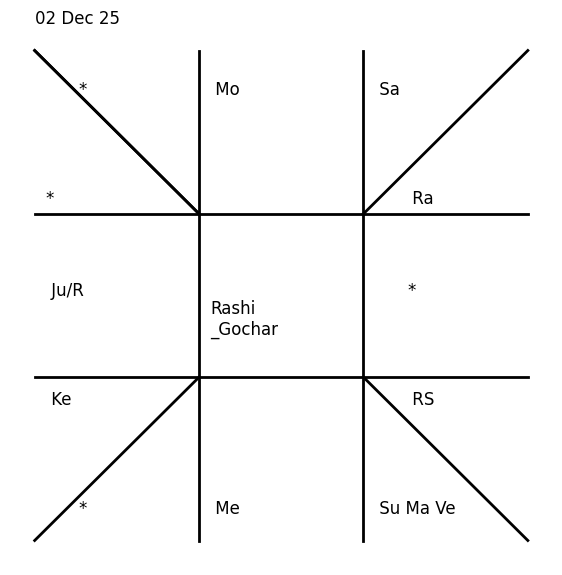

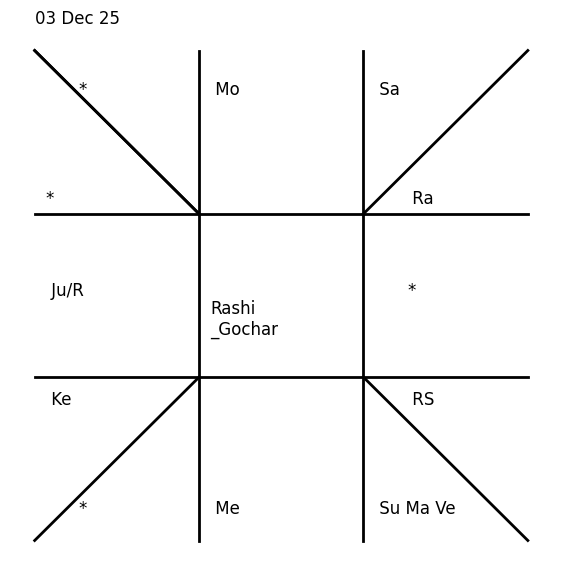

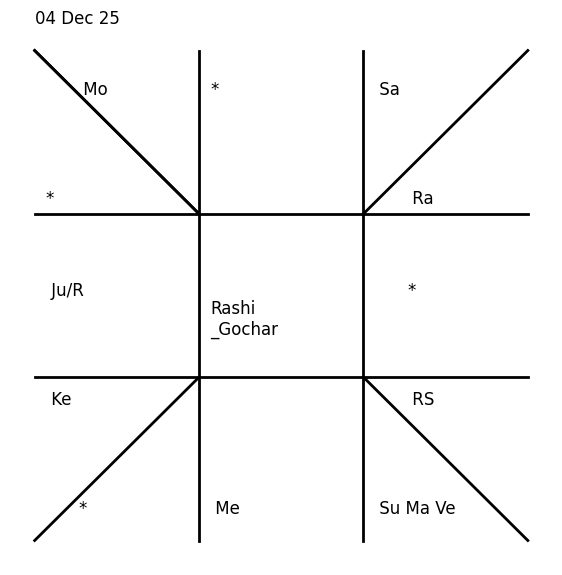

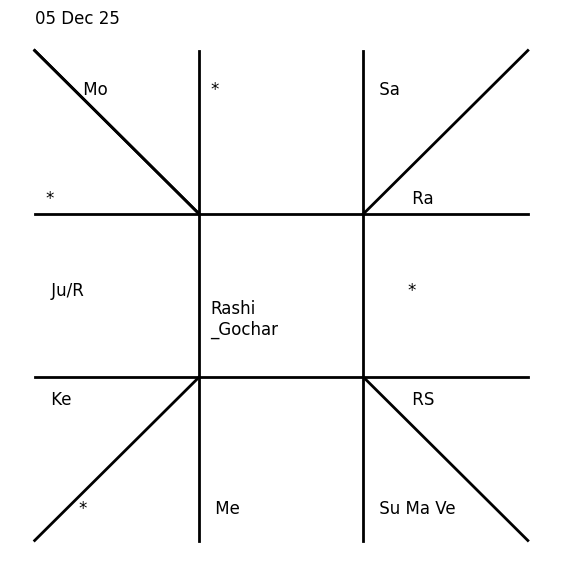

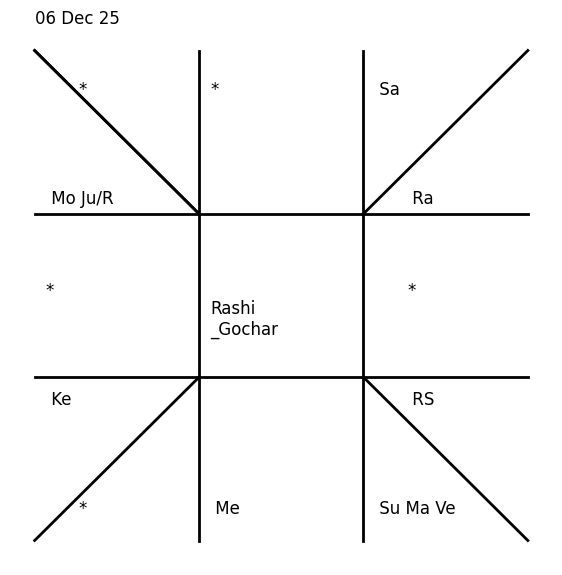

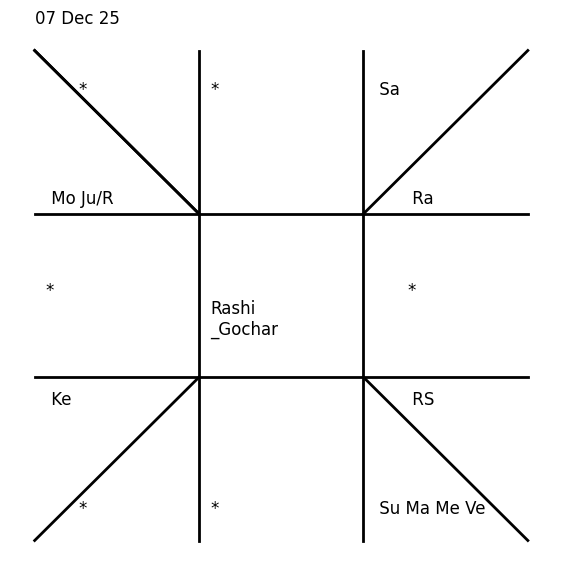

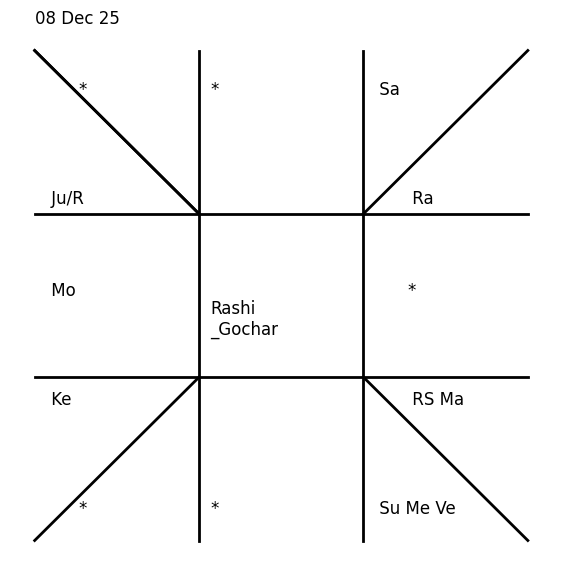

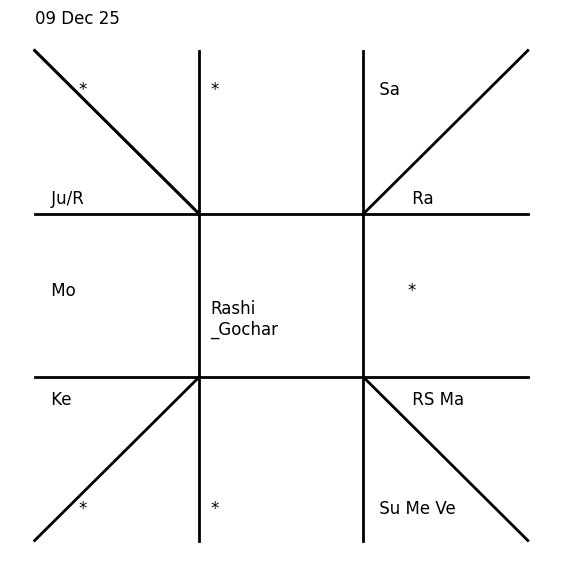

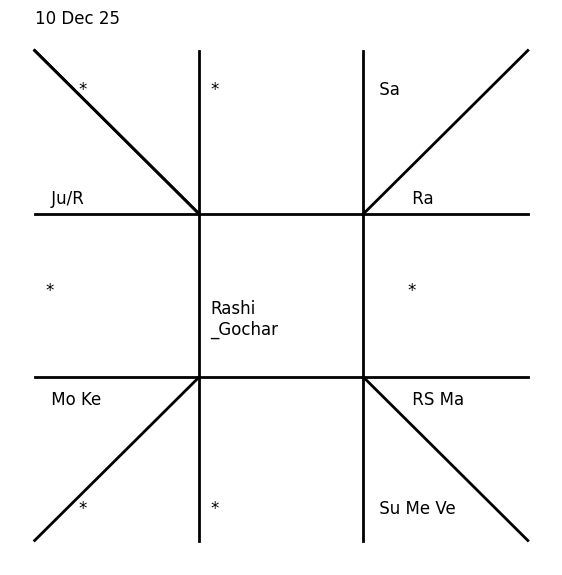

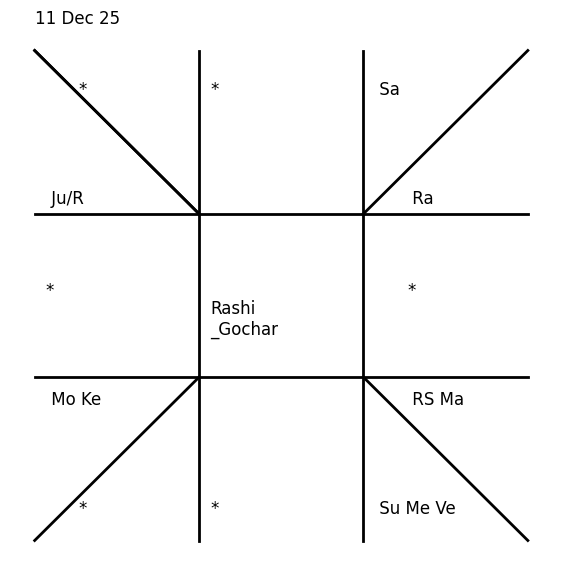

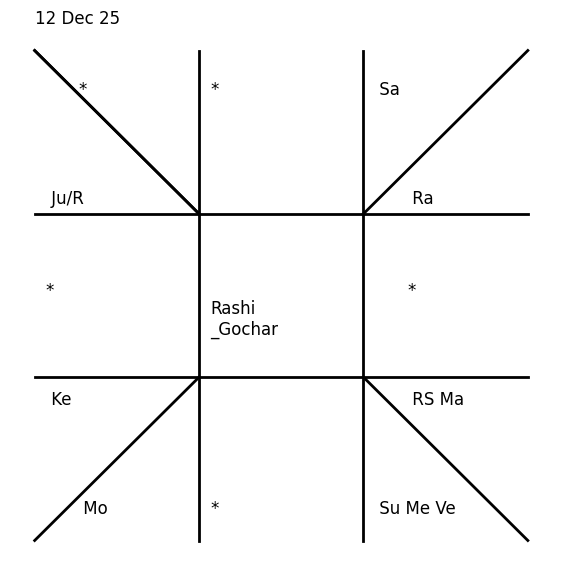

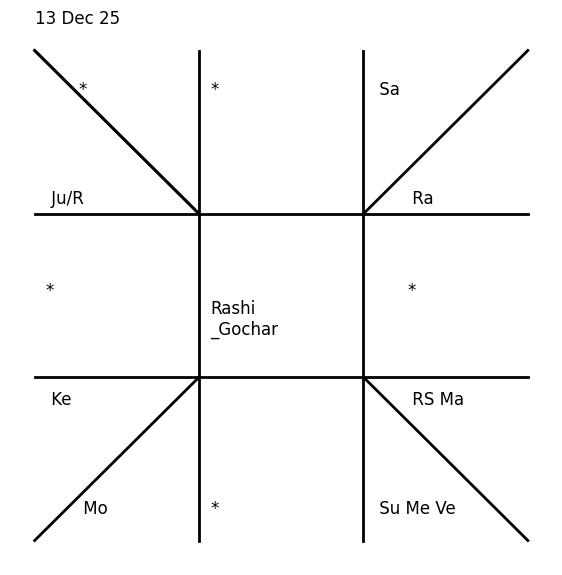

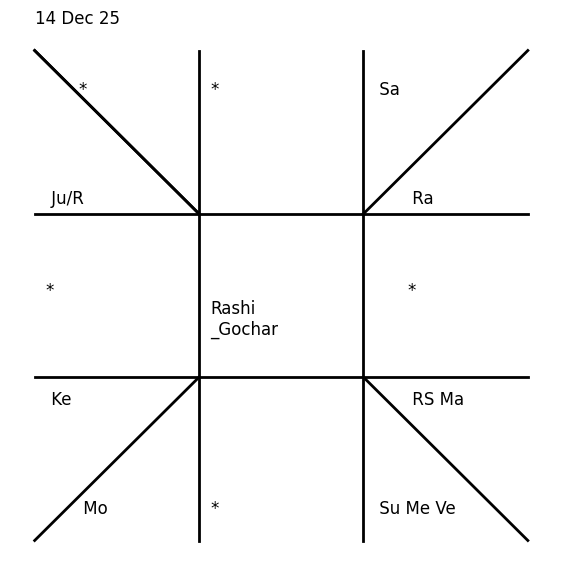

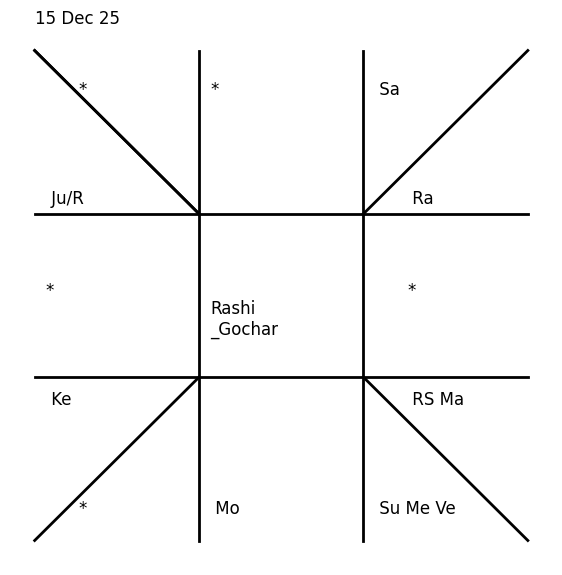

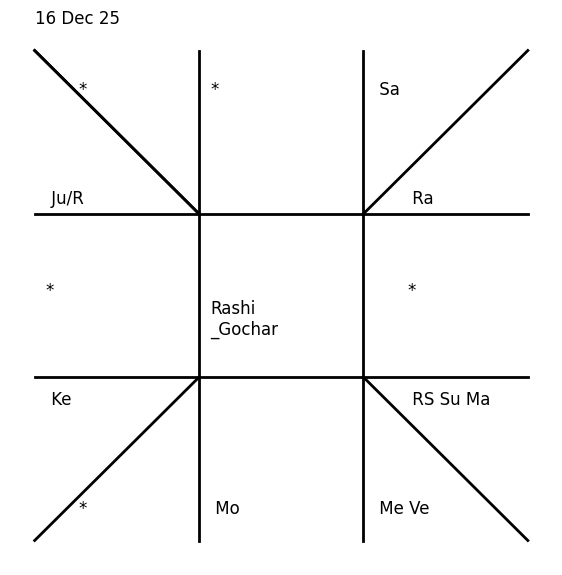

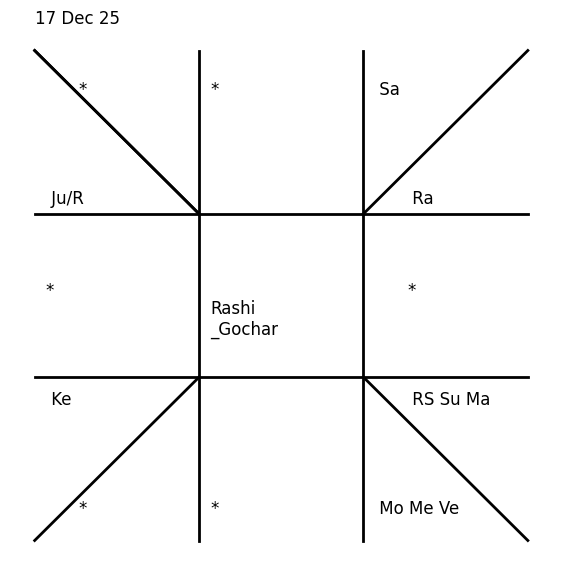

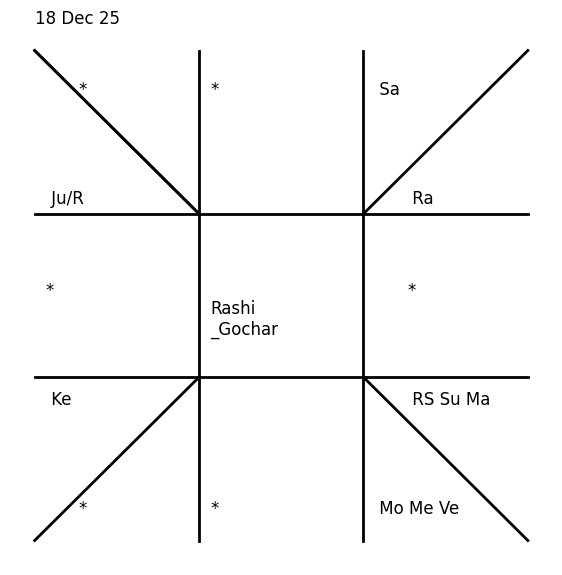

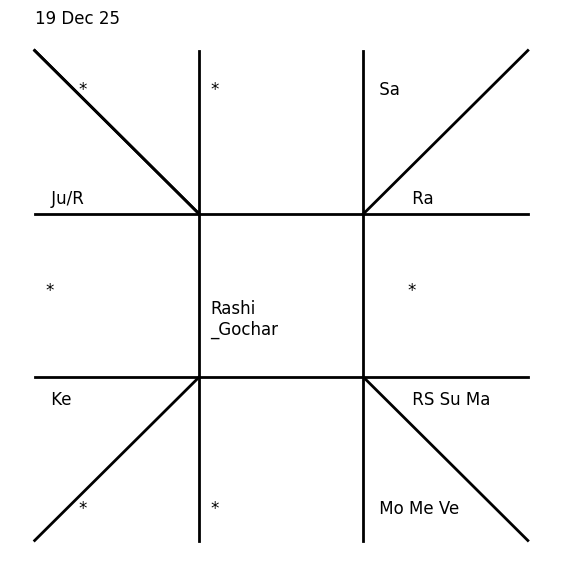

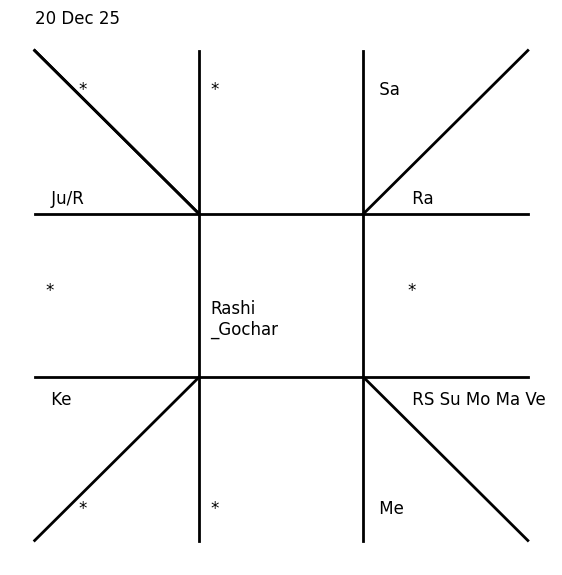

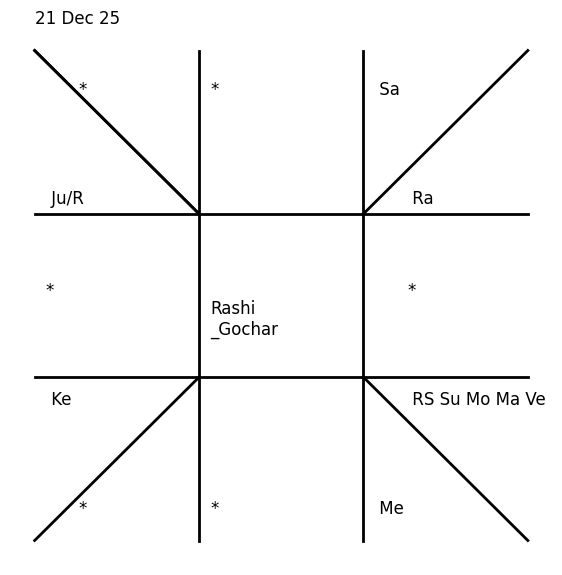

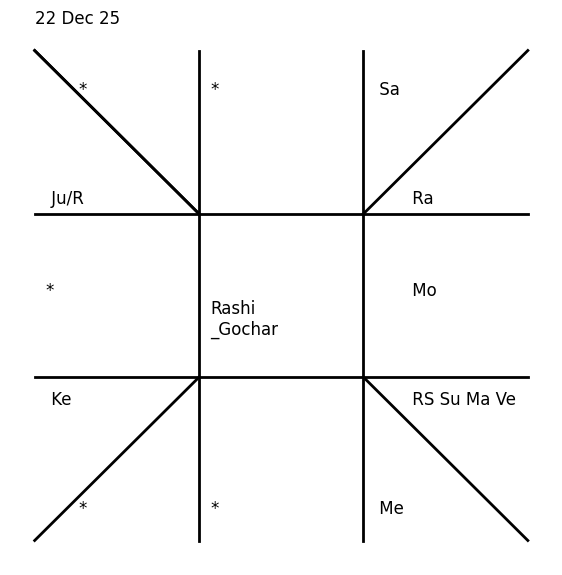

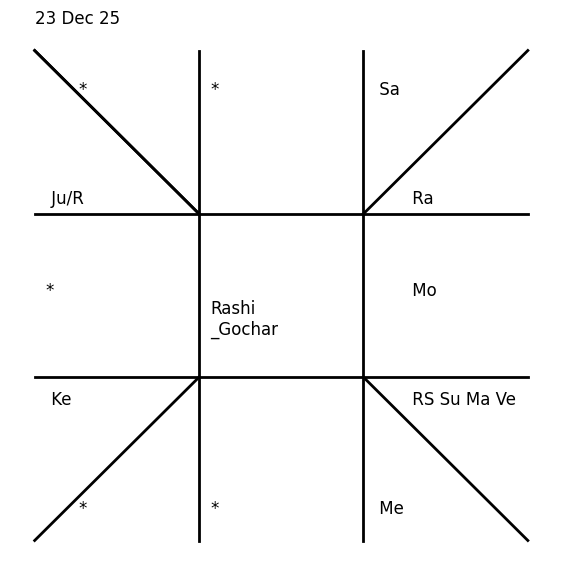

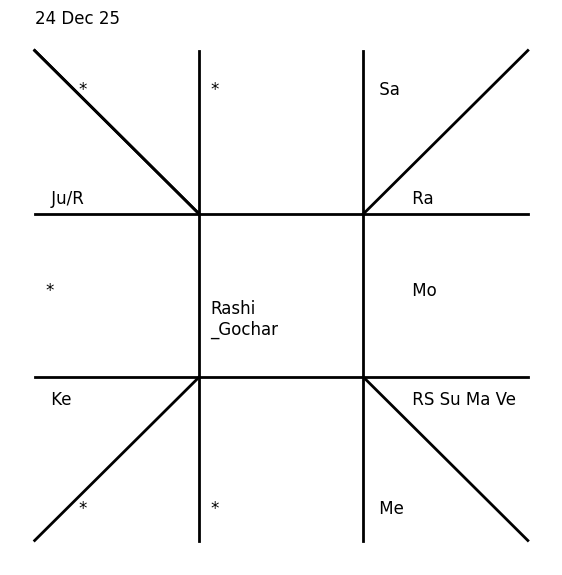

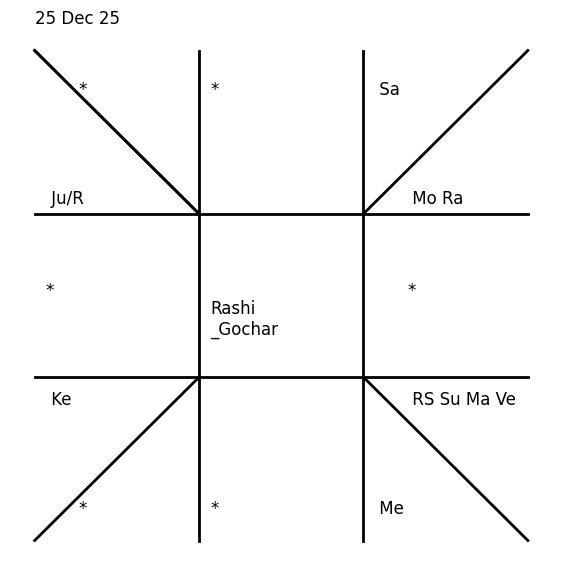

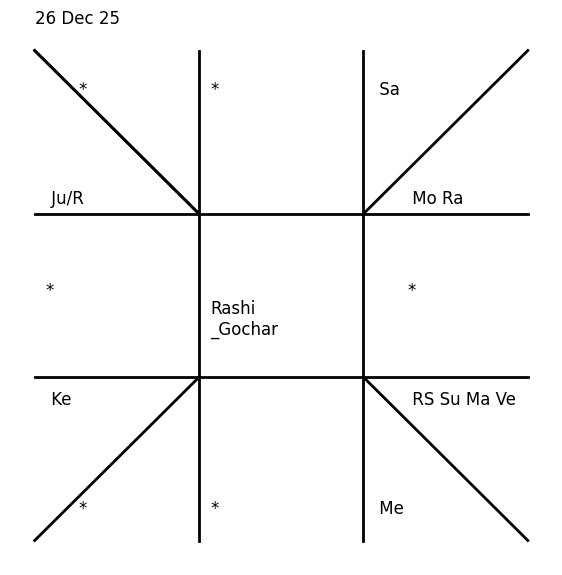

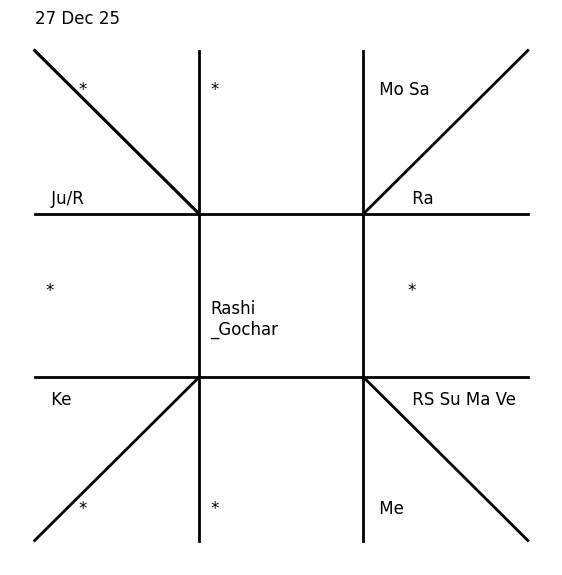

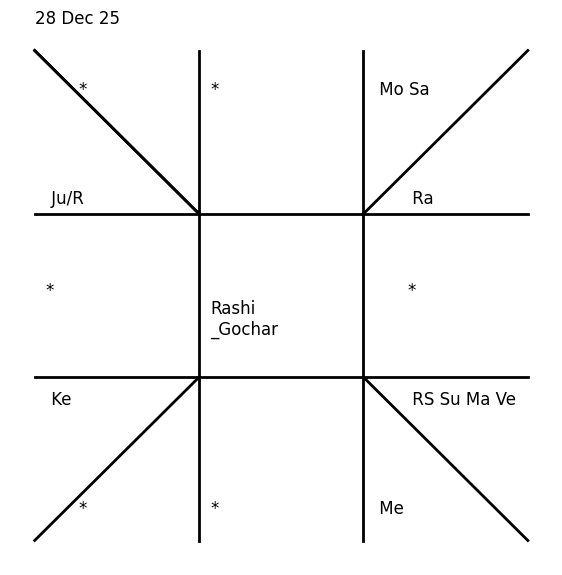

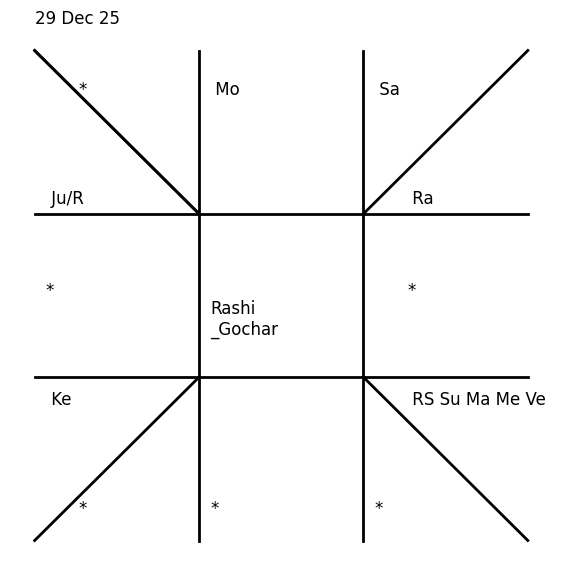

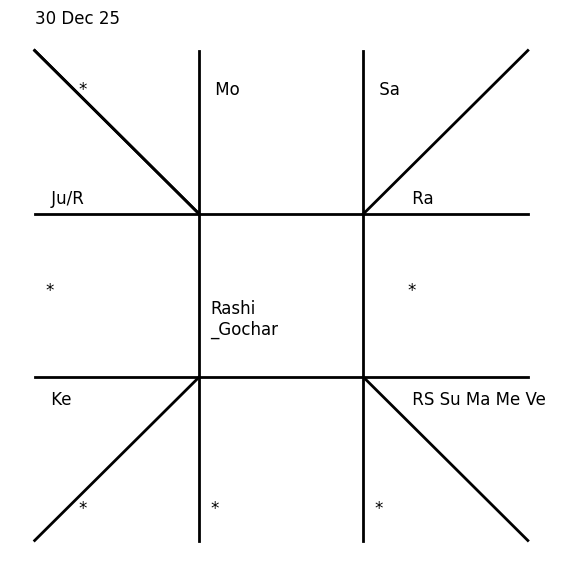

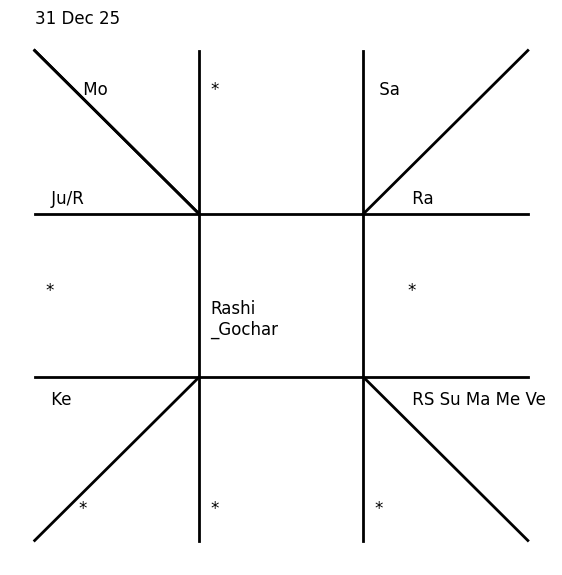

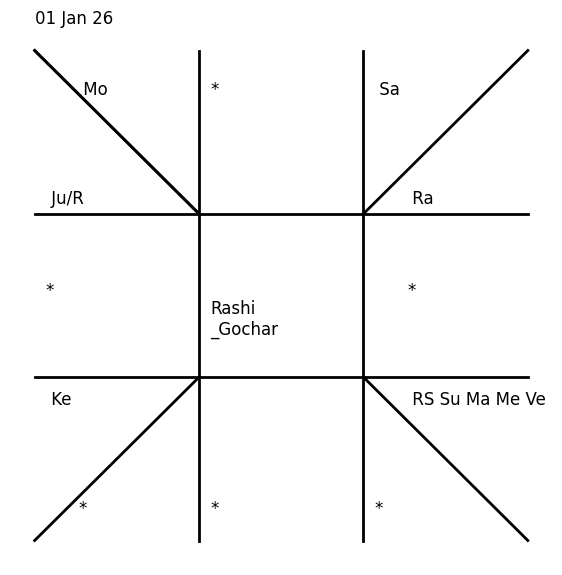

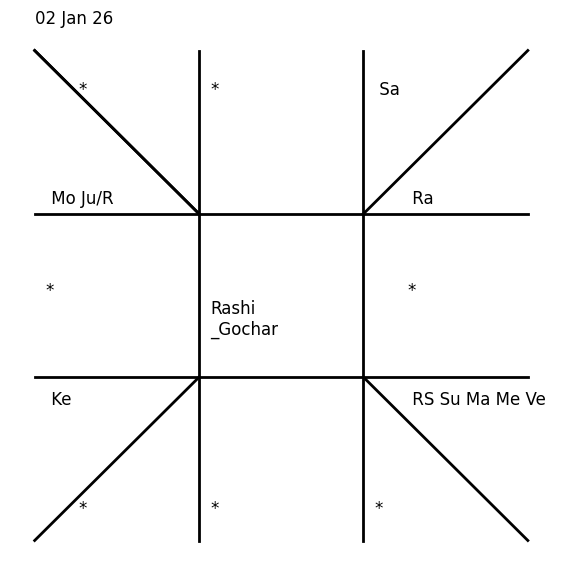

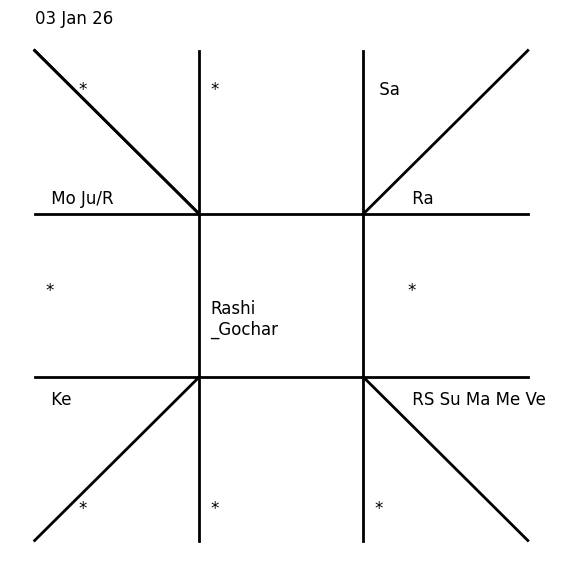

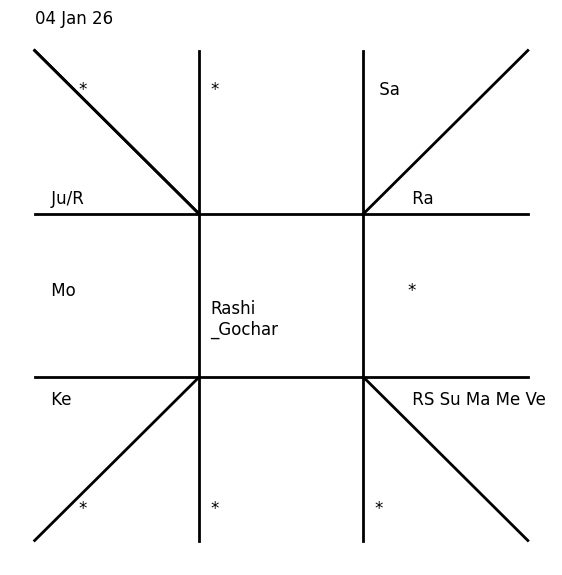

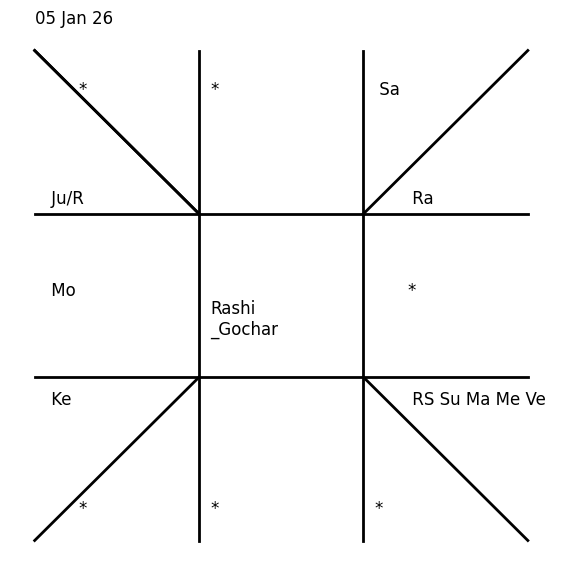

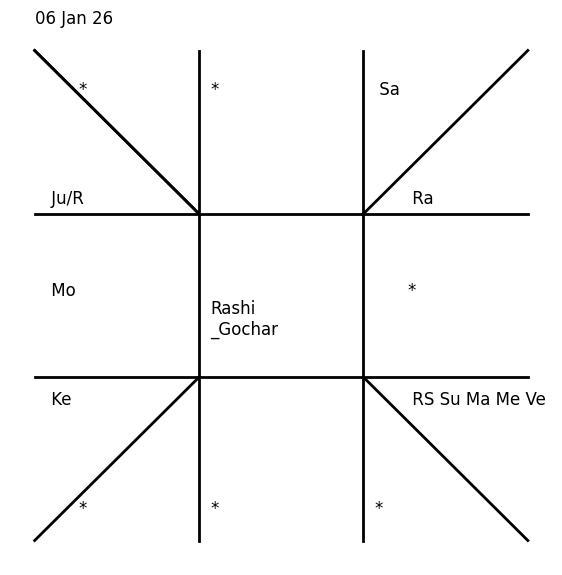

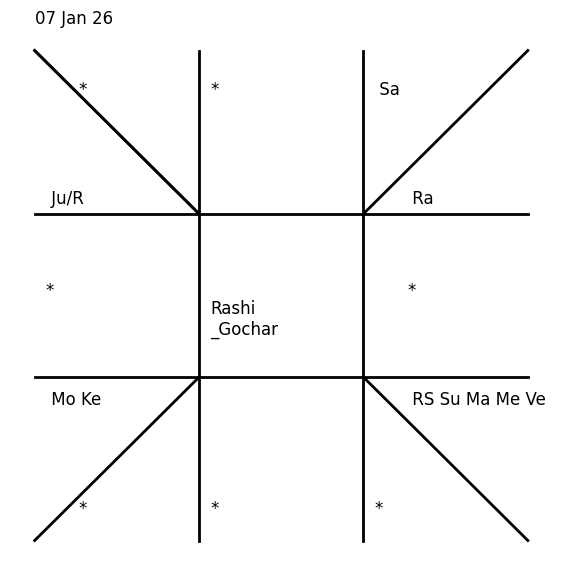

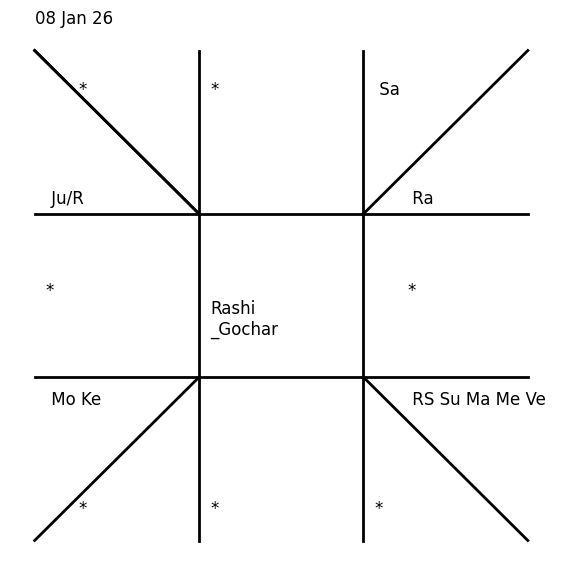

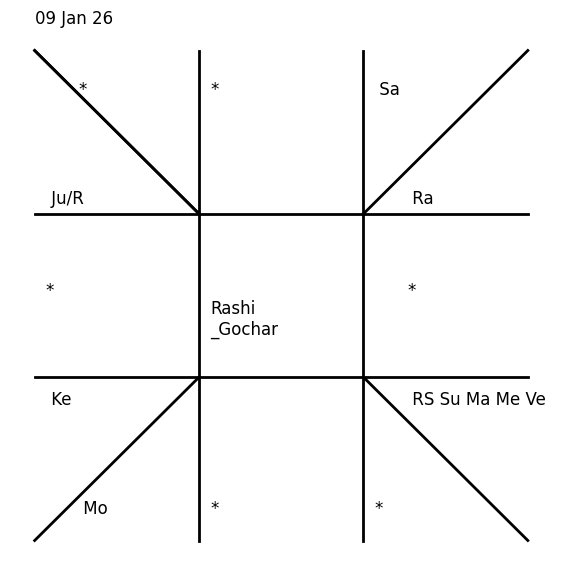

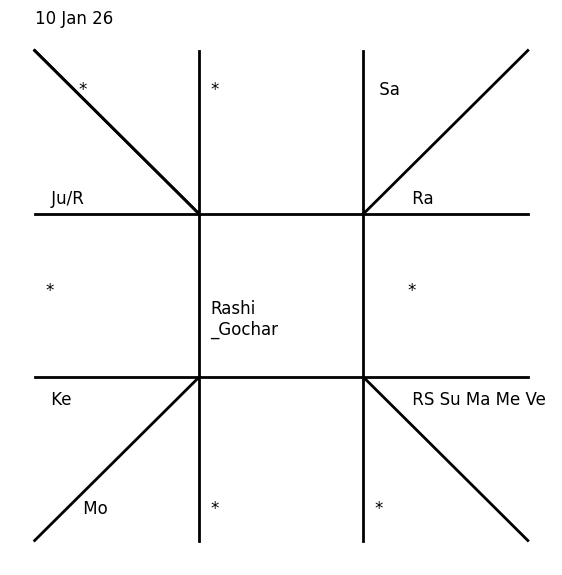

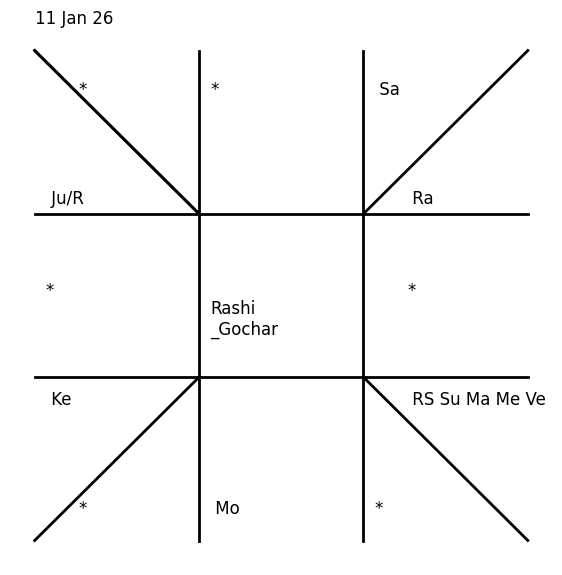

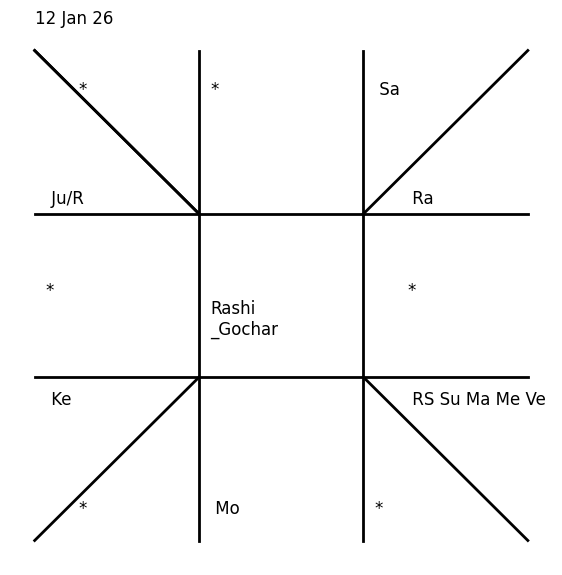

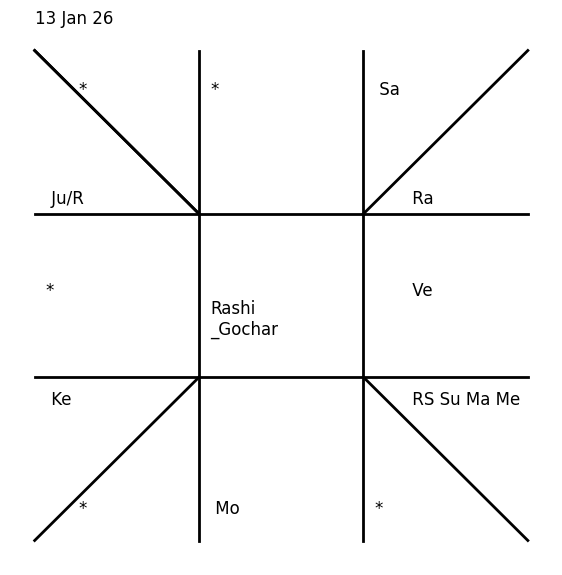

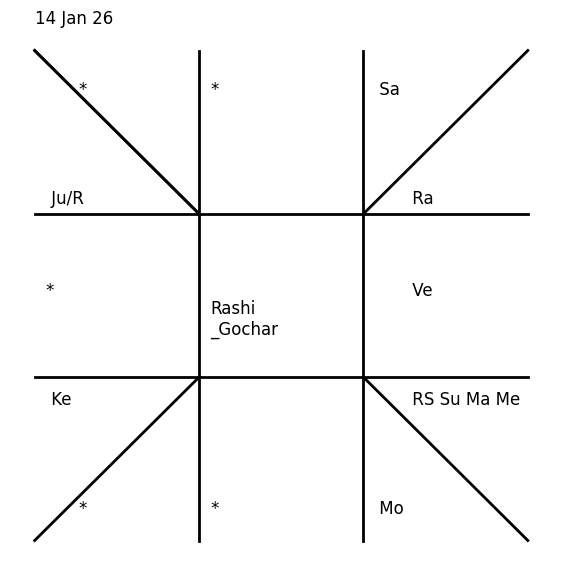

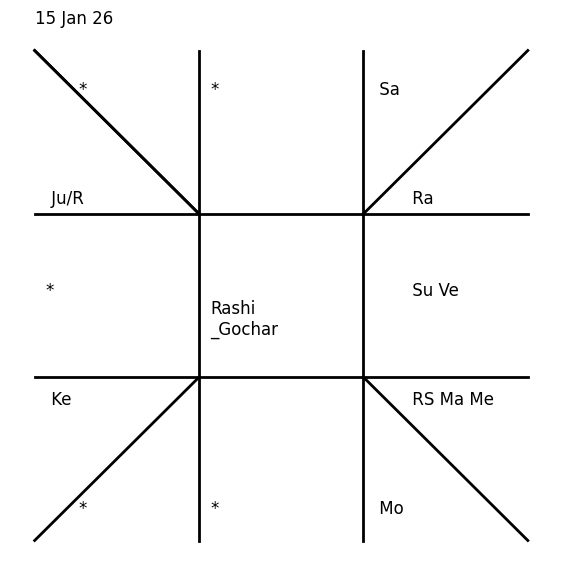

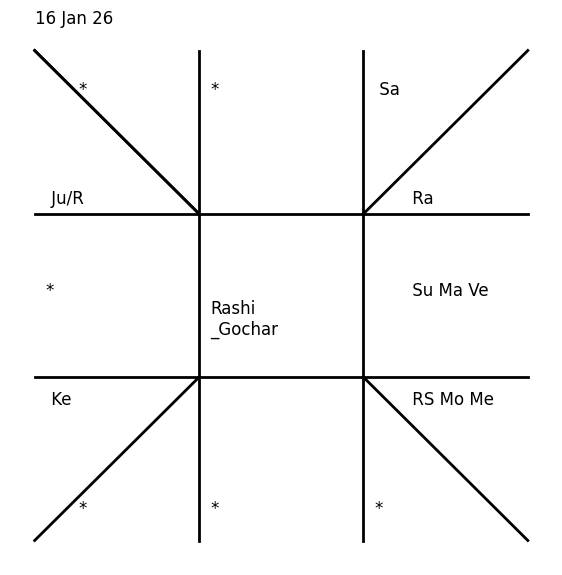

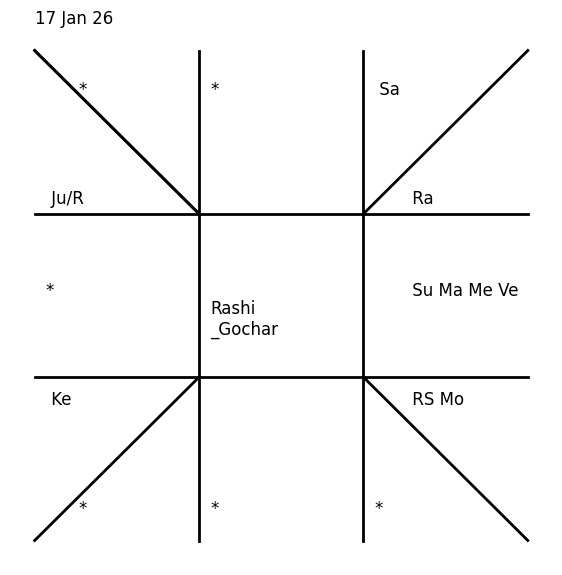

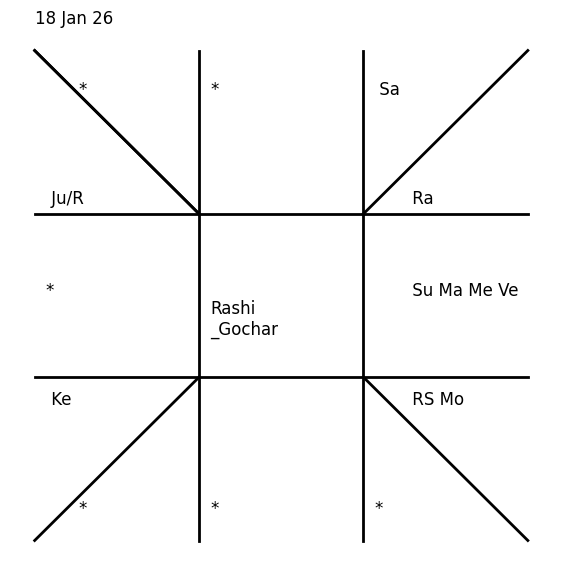

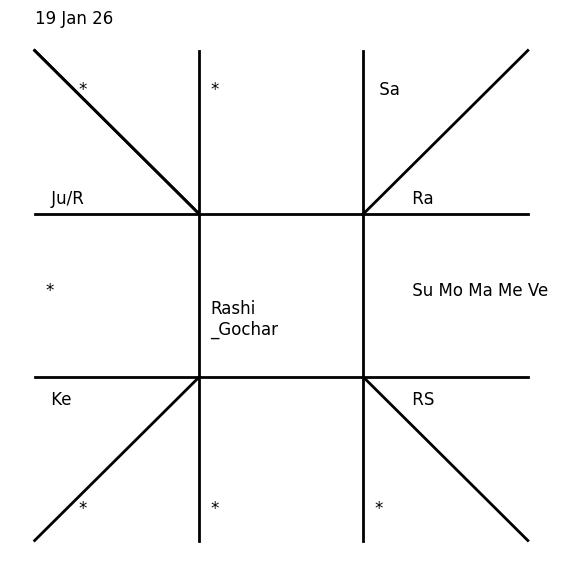

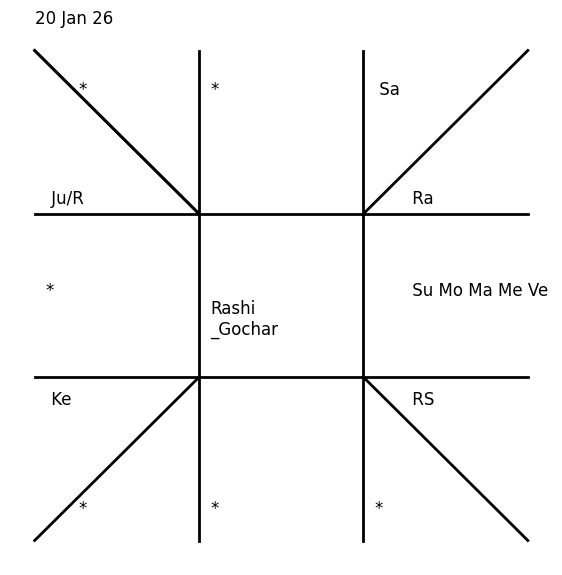

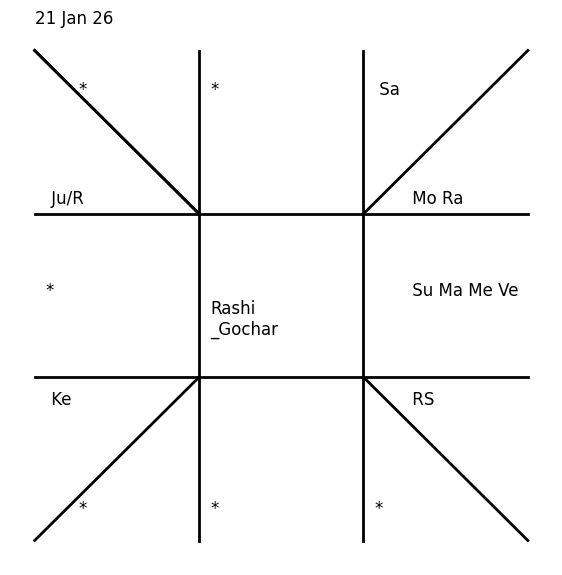

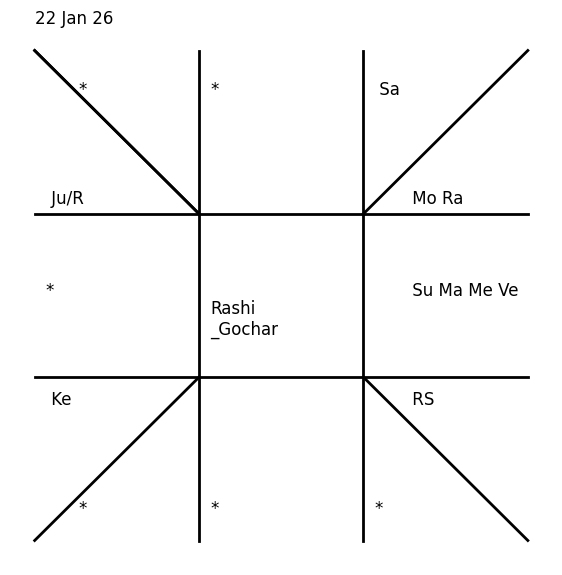

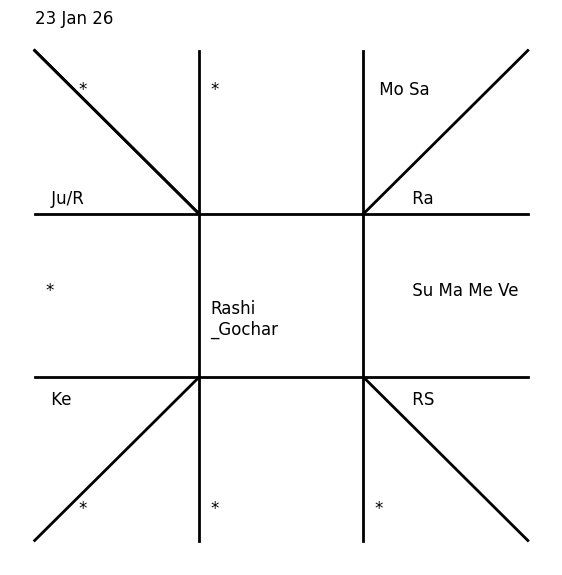

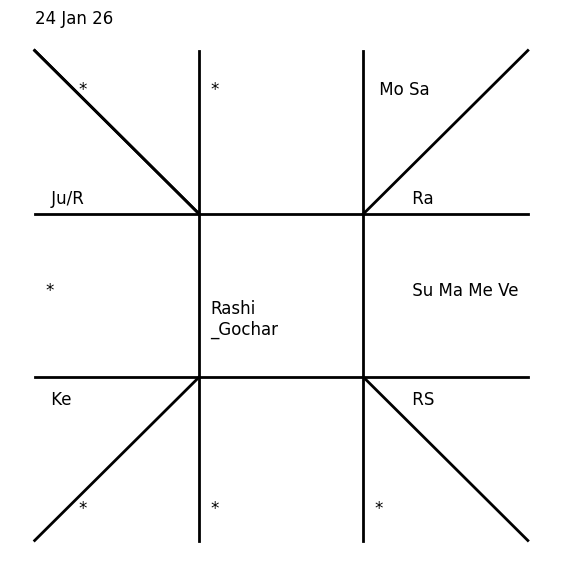

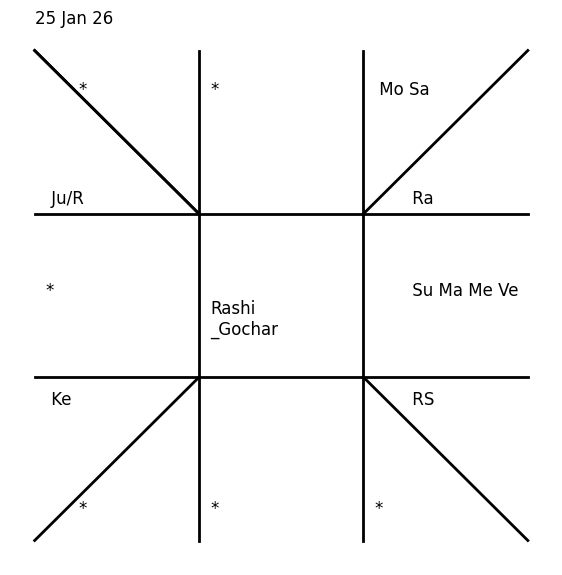

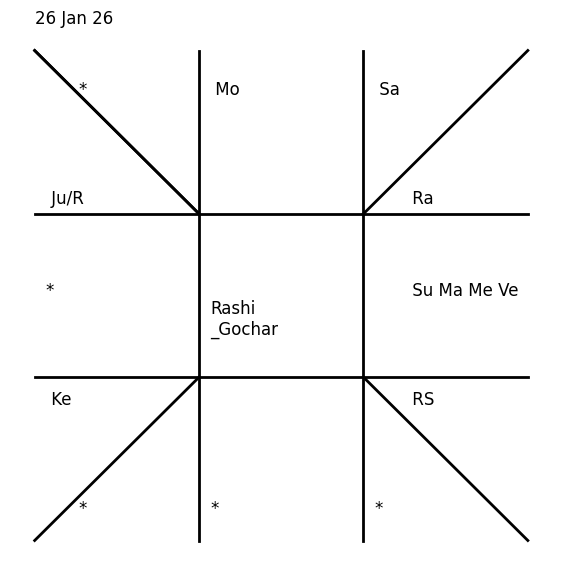

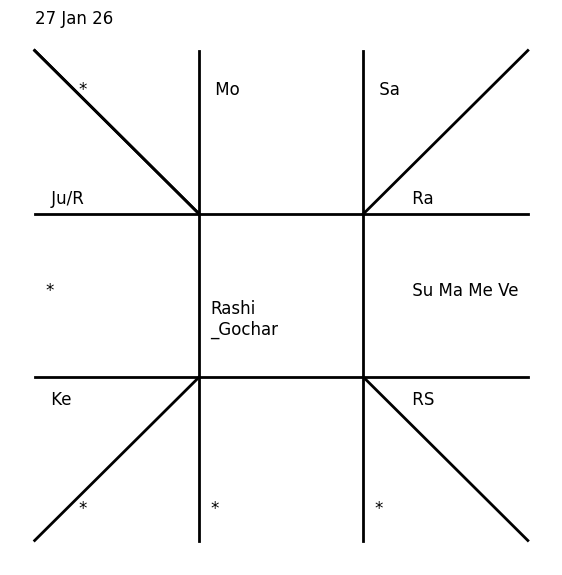

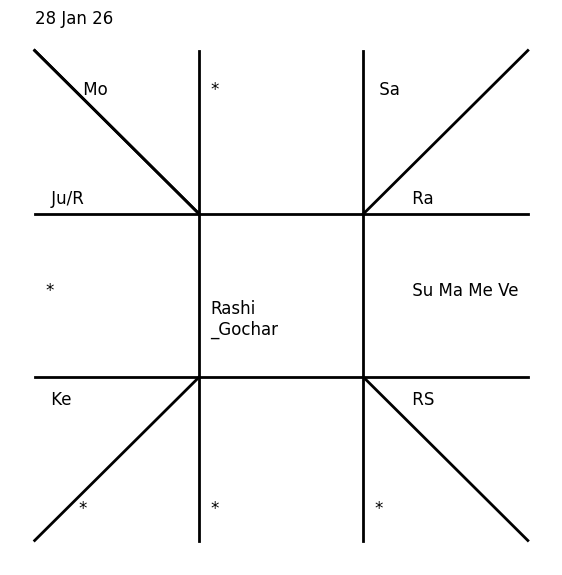

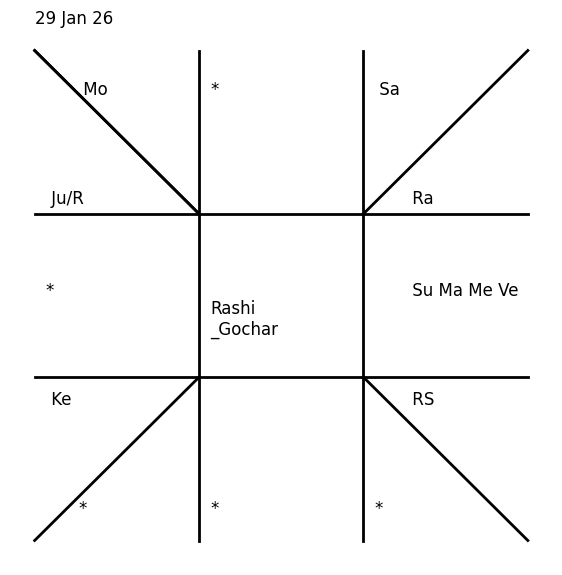

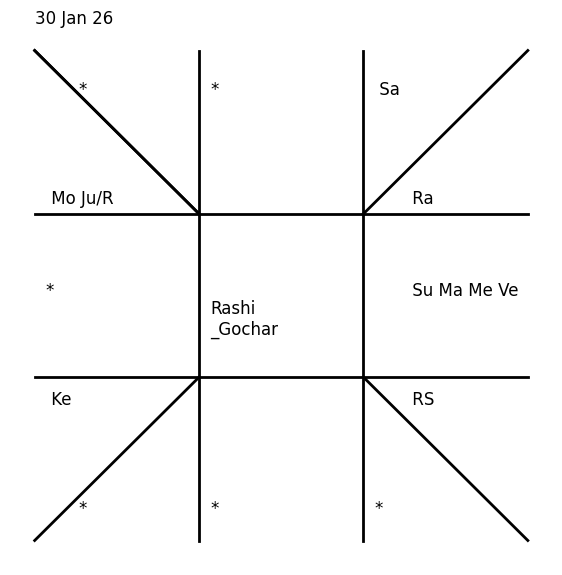

In [13]:
!mkdir ./cImages
!rm ./cImages/*.png

Transitz(60,True,True)       # AllTransits = False, BuildMovie = False, by default

##Transits as a video
reference : https://ostechnix.com/20-ffmpeg-commands-beginners/

In [ ]:
def show_video(video_path, video_width = 600):

  video_file = open(video_path, "r+b").read()

  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

In [ ]:
#!mkdir ./cImages
!rm ./cImages/*.png

In [ ]:
%%capture
#
# Create Images for the Movie
#
Transitz(200,False,True)

In [ ]:
# Create movie
# changing the FPS to 5
#!ffmpeg -f image2 -r 5 -i ./cImages/img%d.png -vcodec mpeg4 -y ./p21Transitz.mp4  # this codec does not work well
#https://shotstack.io/learn/use-ffmpeg-to-convert-images-to-video/

!ffmpeg -loglevel error -framerate 5 -i ./cImages/img%d.png -c:v libx264 -r 5 p21Transitz_0.mp4   # -loglevel error supresses non-error messages


In [ ]:
# see the movie
#
show_video('p21Transitz_0.mp4',300)

In [ ]:
#Add audio
# https://ostechnix.com/20-ffmpeg-commands-beginners/
#

!ffmpeg -loglevel error -i p21Transitz_0.mp4 -i ClockTicking01.mp3 -shortest -c:v copy -c:a aac p21Transitz_1.mp4

In [ ]:
# see the movie
#
show_video('p21Transitz_1.mp4',300)

In [ ]:
#Add a branding image
# https://gist.github.com/bennylope/d5d6029fb63648582fed2367ae23cfd6
# https://stackoverflow.com/questions/20847674/ffmpeg-libx264-height-not-divisible-by-2
#
!ffmpeg -loglevel error -i p21Transitz_1.mp4 -i p21Logo.png -filter_complex 'overlay=x=((main_w-overlay_w)/2)-1:y=((main_h-overlay_h)/2)+5'  p21Transitz_2.mp4

In [ ]:
# see the movie
#
show_video('p21Transitz_2.mp4',300)

In [ ]:
# Convert to Whatsapp format
# https://ostechnix.com/convert-videos-to-whatsapp-video-format-with-ffmpeg/
#

!ffmpeg -loglevel error -i p21Transitz_2.mp4 -vcodec libx264 -acodec aac p21Transitz_w.mp4

In [ ]:
# see the movie
#
show_video('p21Transitz_w.mp4',300)

In [ ]:
!ffprobe p21Transitz.mp4

#Chrono Series <br>
In Indic phraseology, tantra is knowledge, a yantra is a device to explore this knowledge and a mantra is the code that unlocks both the tantra and its yantra. Chrono/TYM a sci-fi trilogy that recreates this framework where the first novel Chronotantra defines the contours of a tech driven, futuristic society, the second, Chronoyantra, describes a device used to explore the genesis of this society, while the third, Chronomantra finally reveals the code, the key, that unlocks this puzzle.  [More information](http://bit.ly/chronobooks) <br>
![alt text](https://blogger.googleusercontent.com/img/b/R29vZ2xl/AVvXsEjdu_ajYwBRzk5iFYlcs59ZoRMMg6rhNm4JERKspvFJoveJsnfwRlzMICiC37UOja_Bd4sbfLA1pyyBbe0mj3tUfDBXoqCzNUDw3Wux7acoJBaLkWjAvJXfa7drRY2GQRAlFxEY9O7a7raY4RKy7cA3Uxgf5QsaZQ99C9GfXxFSex_rke8ROhAn41t8zOqK/s1640/tymBanner01_3.png)